<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/Applications_100m_Sprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp "drive/My Drive/Colab Notebooks/bounded lognorm/bounded_lognorm.py" .
from bounded_lognorm import bounded_lognorm

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import norm, truncnorm, lognorm, skew, kurtosis, normaltest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [10, 10/1.6]

What are the fastest possible 100m sprint times?

Let's first load data from the 2004-2016 Olympics. See [here](https://deepblue.lib.umich.edu/data/concern/data_sets/cr56n184r?locale=en) for details on this dataset.

In [ ]:
url = 'https://deepblue.lib.umich.edu/data/downloads/qn59q4716?locale=en'
sprint_data = pd.read_csv(url, encoding="ISO-8859-1")
sprint_data.head()

,POS,BIB,ATHLETE,COUNTRY,MARK,RxnTime,Race,Round,Gender,Year
0,1.0,NaN,Usain BOLT,JAMJAM,10.20 Q,0.186,100 m,Heats,M,2008
1,2.0,NaN,Daniel BAILEY,ANTANT,10.24 Q,0.198,100 m,Heats,M,2008
2,3.0,NaN,Vicente DE LIMA,BRABRA,10.26 Q,0.168,100 m,Heats,M,2008
3,4.0,NaN,Henry VIZCAÍNO,CUBCUB,10.28 q,0.157,100 m,Heats,M,2008
4,5.0,NaN,Fabio CERUTTI,ITAITA,10.49,0.136,100 m,Heats,M,2008


Isolate the 100m sprint times, clean up the `MARK` field (time in seconds), and convert to average speed (meters per second). 

In [ ]:
sprint_data = sprint_data[sprint_data.Race == "100 m"]
sprint_data['speed'] = sprint_data.MARK.str.split(expand=True)[0]
sprint_data['speed'] = pd.to_numeric(sprint_data['speed'],'coerce')
sprint_data = sprint_data[sprint_data['speed']>0]
sprint_data['speed'] = 100 / sprint_data['speed']
sprint_data.head()

,POS,BIB,ATHLETE,COUNTRY,MARK,RxnTime,Race,Round,Gender,Year,speed
0,1.0,NaN,Usain BOLT,JAMJAM,10.20 Q,0.186,100 m,Heats,M,2008,9.803922
1,2.0,NaN,Daniel BAILEY,ANTANT,10.24 Q,0.198,100 m,Heats,M,2008,9.765625
2,3.0,NaN,Vicente DE LIMA,BRABRA,10.26 Q,0.168,100 m,Heats,M,2008,9.746589
3,4.0,NaN,Henry VIZCAÍNO,CUBCUB,10.28 q,0.157,100 m,Heats,M,2008,9.727626
4,5.0,NaN,Fabio CERUTTI,ITAITA,10.49,0.136,100 m,Heats,M,2008,9.532888


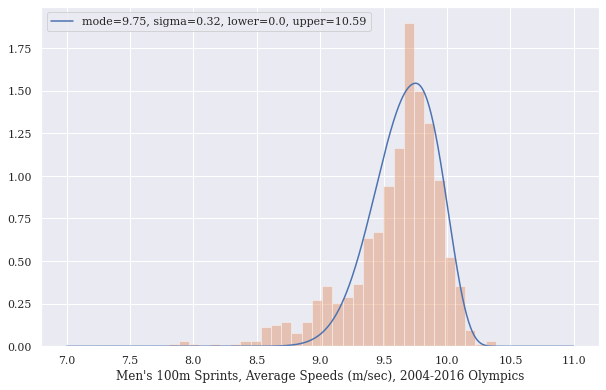

In [ ]:
speeds_M = sprint_data[sprint_data.Gender == 'M']['speed']
shapes, results = bounded_lognorm.fit(speeds_M, MLE=False, verbose=True,
                                      flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(7, 11, len(speeds_M))
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(speeds_M[speeds_M>7], kde=False, norm_hist=True)
plt.xlabel("Men's 100m Sprints, Average Speeds (m/sec), 2004-2016 Olympics")
plt.legend()
plt.show()

Convert the estimated upper bound from average speed (m/sec) to time (sec/100m).

In [ ]:
bpt = 100/shapes[-1] 
bpt.round(2)

9.44

With a 95% confidence interval of

In [ ]:
stdev = np.sqrt(np.diag(results[1]))[-1]
conf_interval = np.array([shapes[-1] + 2 * stdev, 
                          shapes[-1] - 2 * stdev])
(100/conf_interval).round(2)

array([9.21, 9.68])

For comparison, Usain Bolt holds the current record of 9.58 seconds, set at the World Championships in 2009, so outside this sample. The estimates are consistent with anecdotes that Bolt sometimes showboats before the finish line and could have done better had he given 100%. Also you can find another estimate of 9.44 at [this article](https://www.bbc.com/future/article/20120712-will-we-ever-run-100m-in-9-secs).

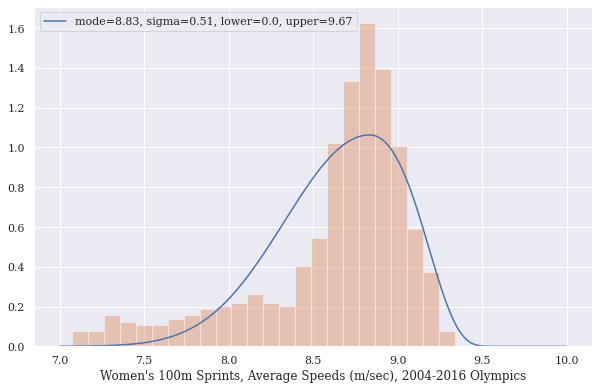

In [ ]:
speeds_W = sprint_data[sprint_data.Gender == 'F']['speed']
shapes, results = bounded_lognorm.fit(speeds_W, 
                                      MLE=False, verbose=True,
                                      fmode=speeds_W.mode()[0],
                                      flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(7, 10, len(speeds_W))
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(speeds_W[speeds_W>7], kde=False, norm_hist=True)
plt.xlabel("Women's 100m Sprints, Average Speeds (m/sec), 2004-2016 Olympics")
plt.legend()
plt.show()

Convert the estimated upper bound from average speed (m/sec) to time (sec/100m).

In [ ]:
bpt = 100/shapes[-1] 
bpt.round(2)

10.34

In [ ]:
stdev = np.sqrt(np.diag(results[1]))[-1]
conf_interval = np.array([shapes[-1] + 2 * stdev, 
                          shapes[-1] - 2 * stdev])
(100/conf_interval).round(2)

array([10.25, 10.43])

For comparison, Florence Griffith-Joyner holds the current record of 10.49 seconds, set in 1988(!), so outside this sample. 

But aren't we assuming that the upper bound, which is outside the range of the sample data, is nonetheless inherent in the data?

Here is an example of a random sample of 10,000 fictional runners, each having 10 qualities with values ranging from 0 to 1. The sum of the runners' qualities therefore can range from 0 to 10. The perfect runner is a 10 and the perfectly worst runner is a 0

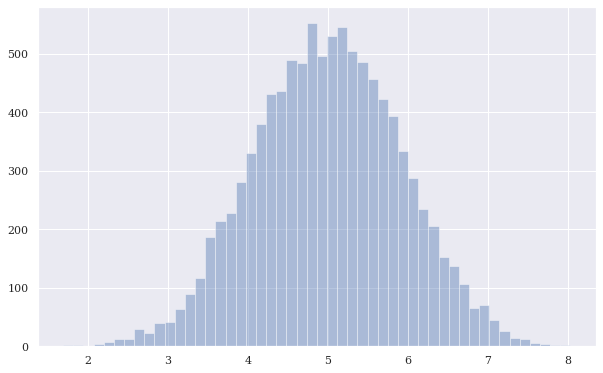

In [ ]:
runners = np.random.random_sample(size=(10, 10000))
runner_sums = runners.sum(axis=0)
sns.distplot(runner_sums, kde=False)

Say we don't know the value sum of the perfect runner, but we do of the worst (0). Let's estimate the perfect runner.

In [ ]:
shapes, results = bounded_lognorm.fit(runner_sums, 
                                      MLE=False, verbose=True,
                                      flower=0)
upper_estd = shapes[-1]
print("The best possible runner, estimated:", upper_estd.round(2))

The best possible runner, estimated: 10.1


In [ ]:
stdev = np.sqrt(np.diag(results[1]))[-1]
conf_interval = np.array([upper_estd - 2 * stdev, upper_estd + 2 * stdev])
print("with a ~95% confidence interval of", conf_interval.round(2))

with a ~95% confidence interval of [10.07 10.13]


These are much closer to the theoretically perfect runner (with value sum = 10) than the best from the sample.

In [ ]:
print("The best runner in the sample:", max(runner_sums).round(2))

The best runner in the sample: 8.04
